In [1]:
!pip install git+https://github.com/mimoralea/gym-walk#egg=gym-walk


  Cloning https://github.com/mimoralea/gym-walk to c:\users\sec\appdata\local\temp\pip-install-7qymcfko\gym-walk_aee72db8677540c8a7a8753606cb6171
  Resolved https://github.com/mimoralea/gym-walk to commit b915b94cf2ad16f8833a1ad92ea94e88159279f5
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/mimoralea/gym-walk 'C:\Users\SEC\AppData\Local\Temp\pip-install-7qymcfko\gym-walk_aee72db8677540c8a7a8753606cb6171'


In [2]:
import warnings ; warnings.filterwarnings('ignore')

import itertools
import gym, gym_walk
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm_notebook as tqdm

from itertools import cycle, count

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [3]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)


In [18]:
def value_iteration(P, gamma=1.0, theta=1e-10):
    V = np.zeros(len(P), dtype=np.float64)
    while True:
        Q = np.zeros((len(P), len(P[0])), dtype=np.float64)
        for s in range(len(P)):
            for a in range(len(P[s])):
                for prob, next_state, reward, done in P[s][a]:
                    Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))
        if np.max(np.abs(V - np.max(Q, axis=1))) < theta:
            break
        V = np.max(Q, axis=1)
    pi = lambda s: np.argmax(Q[s])
    return Q, V, pi


def print_policy(pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
    print(title)
    arrs = {k:v for k,v in enumerate(action_symbols)}
    for s in range(len(P)):
        a = pi(s)
        print("| ", end="")
        if np.all([done for action in P[s] for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), arrs[a].rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")


In [19]:
def print_state_value_function(V, P, n_cols=4, prec=3, title='State-value function:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s] for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{}'.format(np.round(v, prec)).rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

def print_action_value_function(Q,
                                optimal_Q=None,
                                action_symbols=('<', '>'),
                                prec=3,
                                title='Action-value function:'):
    vf_types=('',) if optimal_Q is None else ('', '*', 'err')
    headers = ['s',] + [' '.join(i) for i in list(itertools.product(vf_types, action_symbols))]
    print(title)
    states = np.arange(len(Q))[..., np.newaxis]
    arr = np.hstack((states, np.round(Q, prec)))
    if not (optimal_Q is None):
        arr = np.hstack((arr, np.round(optimal_Q, prec), np.round(optimal_Q-Q, prec)))
    print(tabulate(arr, headers, tablefmt="fancy_grid"))

In [20]:
def get_policy_metrics(env, gamma, pi, goal_state, optimal_Q,
                       n_episodes=100, max_steps=200):
    random.seed(123)
    np.random.seed(123)

    reached_goal, episode_reward, episode_regret = [], [], []

    for _ in range(n_episodes):
        state, _ = env.reset(seed=123)  # ✅ Updated reset
        done, steps = False, 0
        episode_reward.append(0.0)
        episode_regret.append(0.0)

        while not done and steps < max_steps:
            action = pi(state)
            regret = np.max(optimal_Q[state]) - optimal_Q[state][action]
            episode_regret[-1] += regret

            next_state, reward, terminated, truncated, _ = env.step(action)  # ✅ Updated step
            done = terminated or truncated
            episode_reward[-1] += (gamma**steps * reward)

            state = next_state
            steps += 1

        reached_goal.append(state == goal_state)

    results = np.array((
        np.sum(reached_goal)/len(reached_goal)*100,  # % success
        np.mean(episode_reward),                     # avg reward
        np.mean(episode_regret)                      # avg regret
    ))
    return results


In [21]:
def get_metrics_from_tracks(env, gamma, goal_state, optimal_Q, pi_track, coverage=0.1):
    total_samples = len(pi_track)
    n_samples = int(total_samples * coverage)
    samples_e = np.linspace(0, total_samples - 1, n_samples, endpoint=True, dtype=int)  # ✅ fixed dtype
    metrics = []

    for e, pi in enumerate(tqdm(pi_track)):
        if e in samples_e or e == 0:  # ✅ avoid IndexError on first element
            metrics.append(get_policy_metrics(
                env,
                gamma=gamma,
                pi=lambda s: pi[s],
                goal_state=goal_state,
                optimal_Q=optimal_Q))
        else:
            metrics.append(metrics[-1])

    metrics = np.array(metrics)
    success_rate_ma, mean_return_ma, mean_regret_ma = np.apply_along_axis(
        moving_average, axis=0, arr=metrics
    ).T
    return success_rate_ma, mean_return_ma, mean_regret_ma


In [22]:
def rmse(x, y, dp=4):
    return np.round(np.sqrt(np.mean((x - y)**2)), dp)
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

def plot_value_function(title, V_track, V_true=None, log=False, limit_value=0.05, limit_items=5):
    np.random.seed(123)
    per_col = 25
    linecycler = cycle(["-", "--", ":", "-."])
    legends = []

    valid_values = np.argwhere(V_track[-1] > limit_value).squeeze()
    if valid_values.size == 0:
        print("No states exceed the limit_value threshold for plotting.")
        return

    items_idxs = np.random.choice(valid_values,
                                  min(len(valid_values), limit_items),
                                  replace=False)
    
    # draw the true values first
    if V_true is not None:
        for i, state in enumerate(V_track.T):
            if i not in items_idxs:
                continue
            if state[-1] < limit_value:
                continue

            label = f'v*({i})'
            plt.axhline(y=V_true[i], color='k', linestyle='-', linewidth=1)
            # Slight vertical offset for text to reduce overlap
            plt.text(len(V_track)*1.02, V_true[i] + 0.01, label)

    # then the estimates
    for i, state in enumerate(V_track.T):
        if i not in items_idxs:
            continue
        if state[-1] < limit_value:
            continue
        line_type = next(linecycler)
        label = f'V({i})'
        p, = plt.plot(state, line_type, label=label, linewidth=3)
        legends.append(p)

    legends.reverse()
    ls = []
    for idx in range(0, len(legends), per_col):
        subset = legends[idx:idx+per_col]
        l = plt.legend(subset, [p.get_label() for p in subset],
                       loc='center right', bbox_to_anchor=(1.25, 0.5))
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]

    if log:
        plt.xscale('log')
    plt.title(title)
    plt.ylabel('State-value function')
    plt.xlabel('Episodes (log scale)' if log else 'Episodes')

    plt.tight_layout()
    plt.show()


In [24]:
def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

In [25]:
import gym

env = gym.make('FrozenLake-v1')
init_state = env.reset()
goal_state = 15        # In 4x4 FrozenLake, state 15 is the bottom-right goal
gamma = 0.99
n_episodes = 3000
P = env.env.P           # Accessing the transition dynamics dictionary from the env

# Printing and plotting parameters
n_cols = 4
svf_prec = 4           # precision for state value function printing
err_prec = 2           # precision for error printing (if used)
avf_prec = 3           # precision for action value function printing

action_symbols = ('<', 'v', '>', '^')  # Direction symbols for FrozenLake actions (Left, Down, Right, Up)

limit_items = 5         # How many states to plot in value function plots
limit_value = 0.0       # Minimum state value threshold for plotting

cu_limit_items = 10
cu_limit_value = 0.0
cu_episodes = 100       # Possibly a cutoff for cumulative plots or smoothing windows


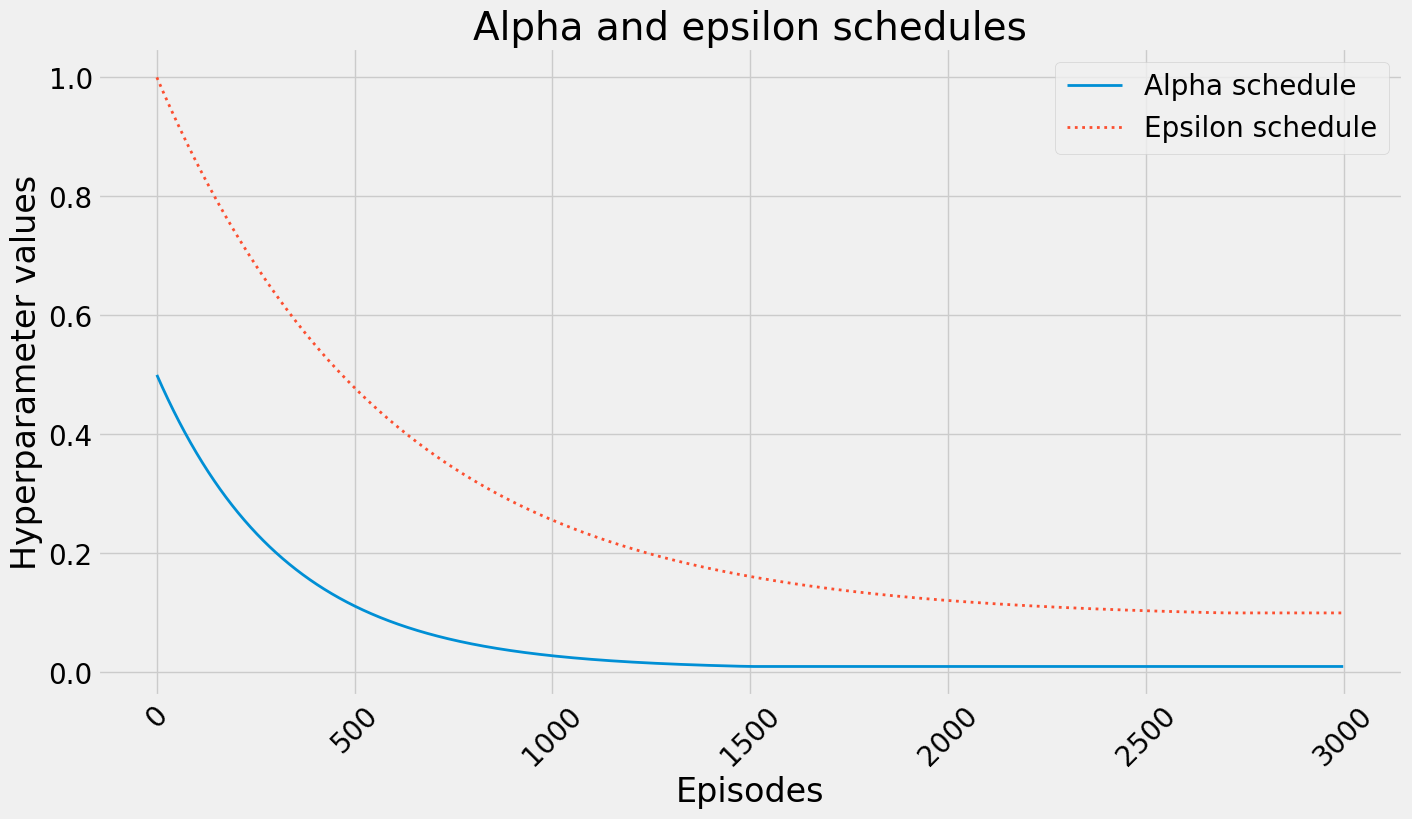

In [26]:
import matplotlib.pyplot as plt

plt.plot(decay_schedule(0.5, 0.01, 0.5, n_episodes),
         '-', linewidth=2,
         label='Alpha schedule')
plt.plot(decay_schedule(1.0, 0.1, 0.9, n_episodes),
         ':', linewidth=2,
         label='Epsilon schedule')
plt.legend(loc=1, ncol=1)

plt.title('Alpha and epsilon schedules')
plt.xlabel('Episodes')
plt.ylabel('Hyperparameter values')
plt.xticks(rotation=45)

plt.show()


In [30]:
optimal_Q, optimal_V, optimal_pi = value_iteration(P, gamma=gamma)

def print_state_value_function(V, P, n_cols=4, prec=3, title='State-value function:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{}'.format(np.round(v, prec)).rjust(6), end=" ")
        if (s + 1) % n_cols == 0:
            print("|")

def print_policy(pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
    print(title)
    arrs = {k: v for k, v in enumerate(action_symbols)}
    for s in range(len(P)):
        a = pi(s)
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), arrs[a].rjust(6), end=" ")
        if (s + 1) % n_cols == 0:
            print("|")

# Now call the print functions and get metrics:
print_state_value_function(optimal_V, P, n_cols=n_cols, prec=4, title='Optimal state-value function:')
print()
print_policy(optimal_pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=n_cols, title='Optimal policy:')
print()

success_rate_op, mean_return_op, mean_regret_op = get_policy_metrics(
    env, gamma=gamma, pi=optimal_pi, goal_state=goal_state, optimal_Q=optimal_Q)

print(f'Reaches goal {success_rate_op:.2f}%. Obtains an average return of {mean_return_op:.4f}. Regret of {mean_regret_op:.4f}')


Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 |
| 04 0.5585 |           | 06 0.3583 |           |
| 08 0.5918 | 09 0.6431 | 10 0.6152 |           |
|           | 13 0.7417 | 14 0.8628 |           |

Optimal policy:
| 00      < | 01      ^ | 02      ^ | 03      ^ |
| 04      < |           | 06      < |           |
| 08      ^ | 09      v | 10      < |           |
|           | 13      > | 14      v |           |

Reaches goal 100.00%. Obtains an average return of 0.7700. Regret of 0.0000


c:\Users\SEC\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [40]:
def generate_trajectory(select_action, Q, epsilon, env, max_steps):
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    state = int(state)
    trajectory = []

    for _ in range(max_steps):
        action = select_action(state, Q, epsilon)
        result = env.step(action)
        
        # Unpack based on Gym API version
        if len(result) == 5:
            next_state, reward, terminated, truncated, info = result
            done = terminated or truncated
        else:
            next_state, reward, done, info = result

        if isinstance(next_state, tuple):
            next_state = next_state[0]
        next_state = int(next_state)

        trajectory.append((state, action, reward, next_state, done))
        state = next_state
        if done:
            break
    return trajectory


In [45]:
def mc_control(env, gamma=0.99, n_episodes=3000, max_steps=100):
    nS = env.observation_space.n
    nA = env.action_space.n

    Q = np.zeros((nS, nA))
    Q_track = np.zeros((n_episodes, nS, nA))
    pi = lambda s: np.argmax(Q[s])

    alphas = decay_schedule(0.5, 0.01, 0.5, n_episodes)
    epsilons = decay_schedule(1.0, 0.1, 0.9, n_episodes)

    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))

    discounts = np.array([gamma ** i for i in range(max_steps)])

    for e in tqdm(range(n_episodes), leave=False):
        trajectory = generate_trajectory(select_action,
                                         Q,
                                         epsilons[e],
                                         env,
                                         max_steps)
        
        trajectory = np.array(trajectory)

        visited = np.zeros((nS, nA), dtype=bool)

        for t, (state, action, reward, next_state, done) in enumerate(trajectory):
            state = int(state)
            action = int(action)

            if visited[state][action]:
                continue

            visited[state][action] = True
            n_steps = len(trajectory) - t
            G = np.sum(discounts[:n_steps] * trajectory[t:, 2].astype(float))
            Q[state][action] = Q[state][action] + alphas[e] * (G - Q[state][action])

        Q_track[e] = Q

    V = np.max(Q, axis=1)
    pi = lambda s: np.argmax(Q[s])
    return Q, V, pi, Q_track, None


In [46]:
Q_mcs, V_mcs, Q_track_mcs = [], [], []

for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed)
    np.random.seed(seed)
    env.reset(seed=seed)  # ✅ Updated seeding

    Q_mc, V_mc, pi_mc, Q_track_mc, pi_track_mc = mc_control(env, gamma=gamma, n_episodes=n_episodes)
    Q_mcs.append(Q_mc)
    V_mcs.append(V_mc)
    Q_track_mcs.append(Q_track_mc)

Q_mc, V_mc, Q_track_mc = np.mean(Q_mcs, axis=0), np.mean(V_mcs, axis=0), np.mean(Q_track_mcs, axis=0)
del Q_mcs
del V_mcs
del Q_track_mcs


All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [47]:
print('Name: SHALINI K Register Number: 212222240095')
print_state_value_function(V_mc, P, n_cols=n_cols,
                           prec=svf_prec, title='State-value function found by FVMC:')
print_state_value_function(optimal_V, P, n_cols=n_cols,
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_mc - optimal_V, P, n_cols=n_cols,
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_mc, optimal_V)))
print()
print_action_value_function(Q_mc,
                            optimal_Q,
                            action_symbols=action_symbols,
                            prec=avf_prec,
                            title='FVMC action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_mc, optimal_Q)))
print()
print_policy(pi_mc, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_mc, mean_return_mc, mean_regret_mc = get_policy_metrics(
    env, gamma=gamma, pi=pi_mc, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_mc, mean_return_mc, mean_regret_mc))

Name: SHALINI K Register Number: 212222240095
State-value function found by FVMC:
| 00 0.2024 | 01 0.1557 | 02 0.1441 | 03 0.0689 |
| 04 0.2264 |           | 06 0.1737 |           |
| 08 0.2657 | 09 0.3354 | 10 0.3493 |           |
|           | 13  0.444 | 14  0.653 |           |
Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 |
| 04 0.5585 |           | 06 0.3583 |           |
| 08 0.5918 | 09 0.6431 | 10 0.6152 |           |
|           | 13 0.7417 | 14 0.8628 |           |
State-value function errors:
| 00  -0.34 | 01  -0.34 | 02  -0.33 | 03  -0.39 |
| 04  -0.33 |           | 06  -0.18 |           |
| 08  -0.33 | 09  -0.31 | 10  -0.27 |           |
|           | 13   -0.3 | 14  -0.21 |           |
State-value function RMSE: 0.2548

FVMC action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │   

In [50]:
def sarsa(env,
          gamma=1.0,
          init_alpha=0.5,
          min_alpha=0.01,
          alpha_decay_ratio=0.5,
          init_epsilon=1.0,
          min_epsilon=0.1,
          epsilon_decay_ratio=0.9,
          n_episodes=3000):
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)

    # Decay schedules for alpha and epsilon
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)

    # Policy based on epsilon-greedy
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) if np.random.random() > epsilon else np.random.randint(nA)

    for e in tqdm(range(n_episodes), leave=False):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        state = int(state)

        action = select_action(state, Q, epsilons[e])
        done = False

        while not done:
            step_result = env.step(action)
            if len(step_result) == 5:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            else:
                next_state, reward, done, _ = step_result

            if isinstance(next_state, tuple):
                next_state = next_state[0]
            next_state = int(next_state)

            next_action = select_action(next_state, Q, epsilons[e])

            # SARSA update
            td_target = reward + gamma * Q[next_state][next_action] * (not done)
            td_delta = td_target - Q[state][action]
            Q[state][action] += alphas[e] * td_delta

            state = next_state
            action = next_action

        Q_track[e] = Q.copy()
        pi_track.append(np.argmax(Q, axis=1).copy())

    best_actions = np.argmax(Q, axis=1)
    pi = lambda s: best_actions[s]

    V = np.max(Q, axis=1)

    return Q, V, pi, Q_track, pi_track


In [51]:
Q_sarsas, V_sarsas, Q_track_sarsas = [], [], []

for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed)
    np.random.seed(seed)
    env.reset(seed=seed)  # Use reset to seed environment properly

    Q_sarsa, V_sarsa, pi_sarsa, Q_track_sarsa, pi_track_sarsa = sarsa(env, gamma=gamma, n_episodes=n_episodes)
    
    Q_sarsas.append(Q_sarsa)
    V_sarsas.append(V_sarsa)
    Q_track_sarsas.append(Q_track_sarsa)

Q_sarsa = np.mean(Q_sarsas, axis=0)
V_sarsa = np.mean(V_sarsas, axis=0)
Q_track_sarsa = np.mean(Q_track_sarsas, axis=0)

del Q_sarsas
del V_sarsas
del Q_track_sarsas


All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [52]:
print('Name: SHALINI K Register Number: 212222240095')
print_state_value_function(V_sarsa, P, n_cols=n_cols,
                           prec=svf_prec, title='State-value function found by Sarsa:')
print_state_value_function(optimal_V, P, n_cols=n_cols,
                           prec=svf_prec, title='Optimal state-value function:')
print_state_value_function(V_sarsa - optimal_V, P, n_cols=n_cols,
                           prec=err_prec, title='State-value function errors:')
print('State-value function RMSE: {}'.format(rmse(V_sarsa, optimal_V)))
print()
print_action_value_function(Q_sarsa,
                            optimal_Q,
                            action_symbols=action_symbols,
                            prec=avf_prec,
                            title='Sarsa action-value function:')
print('Action-value function RMSE: {}'.format(rmse(Q_sarsa, optimal_Q)))
print()
print_policy(pi_sarsa, P, action_symbols=action_symbols, n_cols=n_cols)
success_rate_sarsa, mean_return_sarsa, mean_regret_sarsa = get_policy_metrics(
    env, gamma=gamma, pi=pi_sarsa, goal_state=goal_state, optimal_Q=optimal_Q)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}. Regret of {:.4f}'.format(
    success_rate_sarsa, mean_return_sarsa, mean_regret_sarsa))

Name: SHALINI K Register Number: 212222240095
State-value function found by Sarsa:
| 00 0.1789 | 01 0.1177 | 02 0.1025 | 03 0.0556 |
| 04 0.2017 |           | 06 0.1414 |           |
| 08 0.2515 | 09 0.3488 | 10 0.3691 |           |
|           | 13 0.4748 | 14 0.6801 |           |
Optimal state-value function:
| 00  0.542 | 01 0.4988 | 02 0.4707 | 03 0.4569 |
| 04 0.5585 |           | 06 0.3583 |           |
| 08 0.5918 | 09 0.6431 | 10 0.6152 |           |
|           | 13 0.7417 | 14 0.8628 |           |
State-value function errors:
| 00  -0.36 | 01  -0.38 | 02  -0.37 | 03   -0.4 |
| 04  -0.36 |           | 06  -0.22 |           |
| 08  -0.34 | 09  -0.29 | 10  -0.25 |           |
|           | 13  -0.27 | 14  -0.18 |           |
State-value function RMSE: 0.2641

Sarsa action-value function:
╒═════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════╤═════════╤═════════╤═════════╕
│   s │     < │     v │     > │     ^ │   * < │   * v │   * > │   * ^ │   err < │ 

Name: SHALINI K Register Number: 212222240095


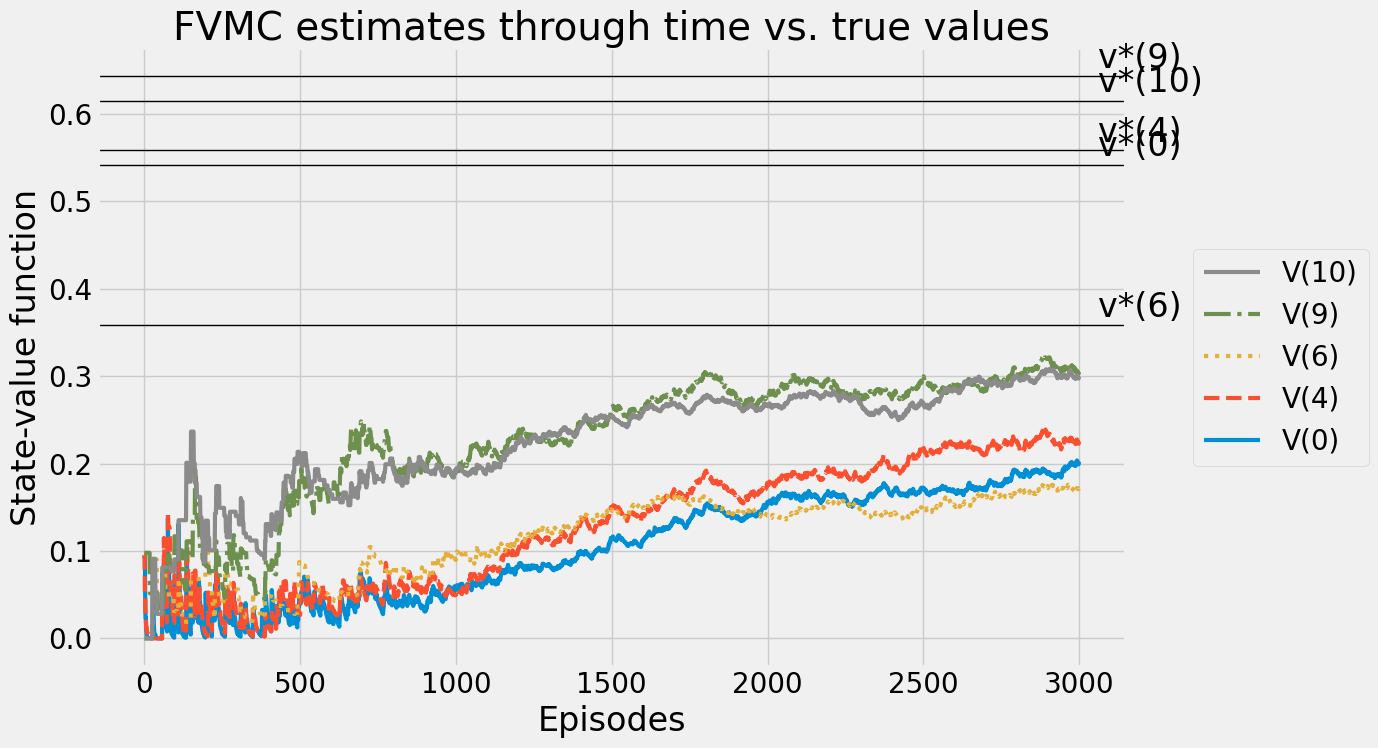

In [53]:
print('Name: SHALINI K Register Number: 212222240095')
plot_value_function(
    'FVMC estimates through time vs. true values',
    np.max(Q_track_mc, axis=2),
    optimal_V,
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)

Name: SHALINI K Register Number: 212222240095


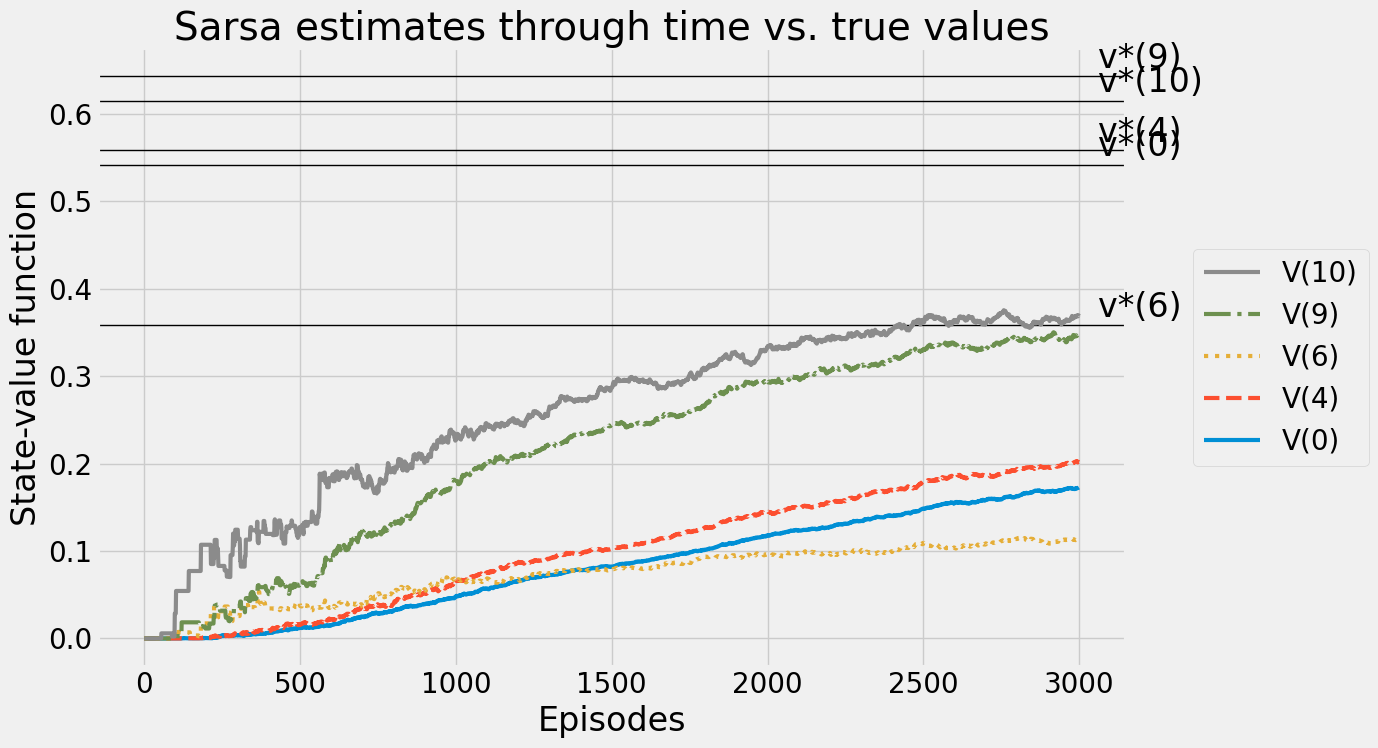

In [54]:
print('Name: SHALINI K Register Number: 212222240095')
plot_value_function(
    'Sarsa estimates through time vs. true values',
    np.max(Q_track_sarsa, axis=2),
    optimal_V,
    limit_items=limit_items,
    limit_value=limit_value,
    log=False)